# **Import Library**

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms

# Set random seeds
np.random.seed(10)
tf.random.set_seed(10)

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# **Dataset Download and Pre-processing**

In [ ]:
# OPTIONAL: If using Kaggle Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamtapendu/chest-x-ray-lungs-segmentation")

print("Path to dataset files:", path)

Resuming download from 3828350976 bytes (26820602 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/iamtapendu/chest-x-ray-lungs-segmentation?dataset_version_number=1 (3828350976/3855171578) bytes left.


100%|██████████| 3.59G/3.59G [00:02<00:00, 11.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamtapendu/chest-x-ray-lungs-segmentation/versions/1


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# OPTIONAL: Load dataset from Google Drive
base_path = '/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/Chest-X-Ray'
metadata_path = '/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/MetaData.csv'

# Read and check
metadata = pd.read_csv(metadata_path)
print("Dataset Overview")
print("================")
print("Metadata Number: " + str(len(metadata)))
print("\nMetadata Head:")
print(metadata.head())
print("\nMetadata Info:")
print(metadata.info())

Dataset Overview
Metadata Number: 704

Metadata Head:
     id gender  age    county  ptb  \
0  1000      1   31  Shenxhen    0   
1  1001      1   64  Shenxhen    0   
2  1002      1   35  Shenxhen    0   
3  1003      1   32  Shenxhen    1   
4  1004      1    2  Shenxhen    1   

                                       remarks  
0                                       normal  
1                                       normal  
2                                       normal  
3               STB,ATB,tuberculosis pleuritis  
4  secondary PTB  in the bilateral upper field  

Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    int64 
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  704 non-null    object
dtypes:

In [ ]:
# For base model, sample dataset to only first 100. In this base model, we get first 50 TB data and 50 non-TB data
ptb_0_sample = metadata[metadata['ptb'] == 0].sample(n=150, random_state=10)
ptb_1_sample = metadata[metadata['ptb'] == 1].sample(n=150, random_state=10)
metadata = pd.concat([ptb_1_sample, ptb_0_sample]).reset_index(drop=True)

# Check data
print("Sampled Dataset Overview")
print("========================")
print("Metadata Number: " + str(len(metadata)))
print("\nMetadata Head:")
print(metadata.head())
print("\nMetadata Info:")
print(metadata.info())

Sampled Dataset Overview
Metadata Number: 300

Metadata Head:
     id gender  age    county  ptb                                  remarks
0  1221      1   25  Shenxhen    1                                Right PTB
1  1167      1   34  Shenxhen    1                                 left PTB
2  1409      1   24  Shenxhen    1                                Right PTB
3  1485      0   43  Shenxhen    1  secondary PTB  in the right upper field
4  1281      1   36  Shenxhen    1              PTB in the left upper field

Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       300 non-null    int64 
 1   gender   300 non-null    object
 2   age      300 non-null    int64 
 3   county   300 non-null    object
 4   ptb      300 non-null    int64 
 5   remarks  300 non-null    object
dtypes: int64(3), object(3)
memory usage: 14.2+ KB
None


In [ ]:
# Preprocess image
def preprocess_image(image_path, mask_path, image_size = (512, 512)):
    # Load and preprocess image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, image_size)
    img = img / 255.0

    # Load and preprocess mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size)
    mask = mask / 255.0

    return img, mask

# Load all images and masks
images = []
masks = []
labels = []

print("Loading images and masks...")
for idx, row in metadata.iterrows():
    img_path = os.path.join(base_path, 'image', f"{row['id']}.png")
    mask_path = os.path.join(base_path, 'mask', f"{row['id']}.png")

    img, mask = preprocess_image(img_path, mask_path)
    images.append(img)
    masks.append(mask)
    labels.append(row['ptb'])

    if (idx + 1) % 100 == 0:
        print(f"Processed {idx + 1} images")

# Convert to numpy arrays
X_images = np.array(images)[..., np.newaxis]
X_masks = np.array(masks)[..., np.newaxis]
y = np.array(labels)

print("\nFinal dataset shapes:")
print(f"Images shape: {X_images.shape}")
print(f"Masks shape: {X_masks.shape}")
print(f"Labels shape: {y.shape}")

# Save pre-processed data to .npy files
np.save('300_X_images.npy', X_images)
np.save('300_X_masks.npy', X_masks)
np.save('300_y.npy', y)

Loading images and masks...
Processed 100 images
Processed 200 images
Processed 300 images

Final dataset shapes:
Images shape: (300, 512, 512, 1)
Masks shape: (300, 512, 512, 1)
Labels shape: (300,)


# **Start here w/ Numpy Vector**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load arrays from .npy files (START here if you have the data)
X_images = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/X_images.npy')
X_masks = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/X_masks.npy')
y = np.load('/content/drive/My Drive/Colab Notebooks/Dataset/Adv ML Dataset/y.npy')

Sample image:


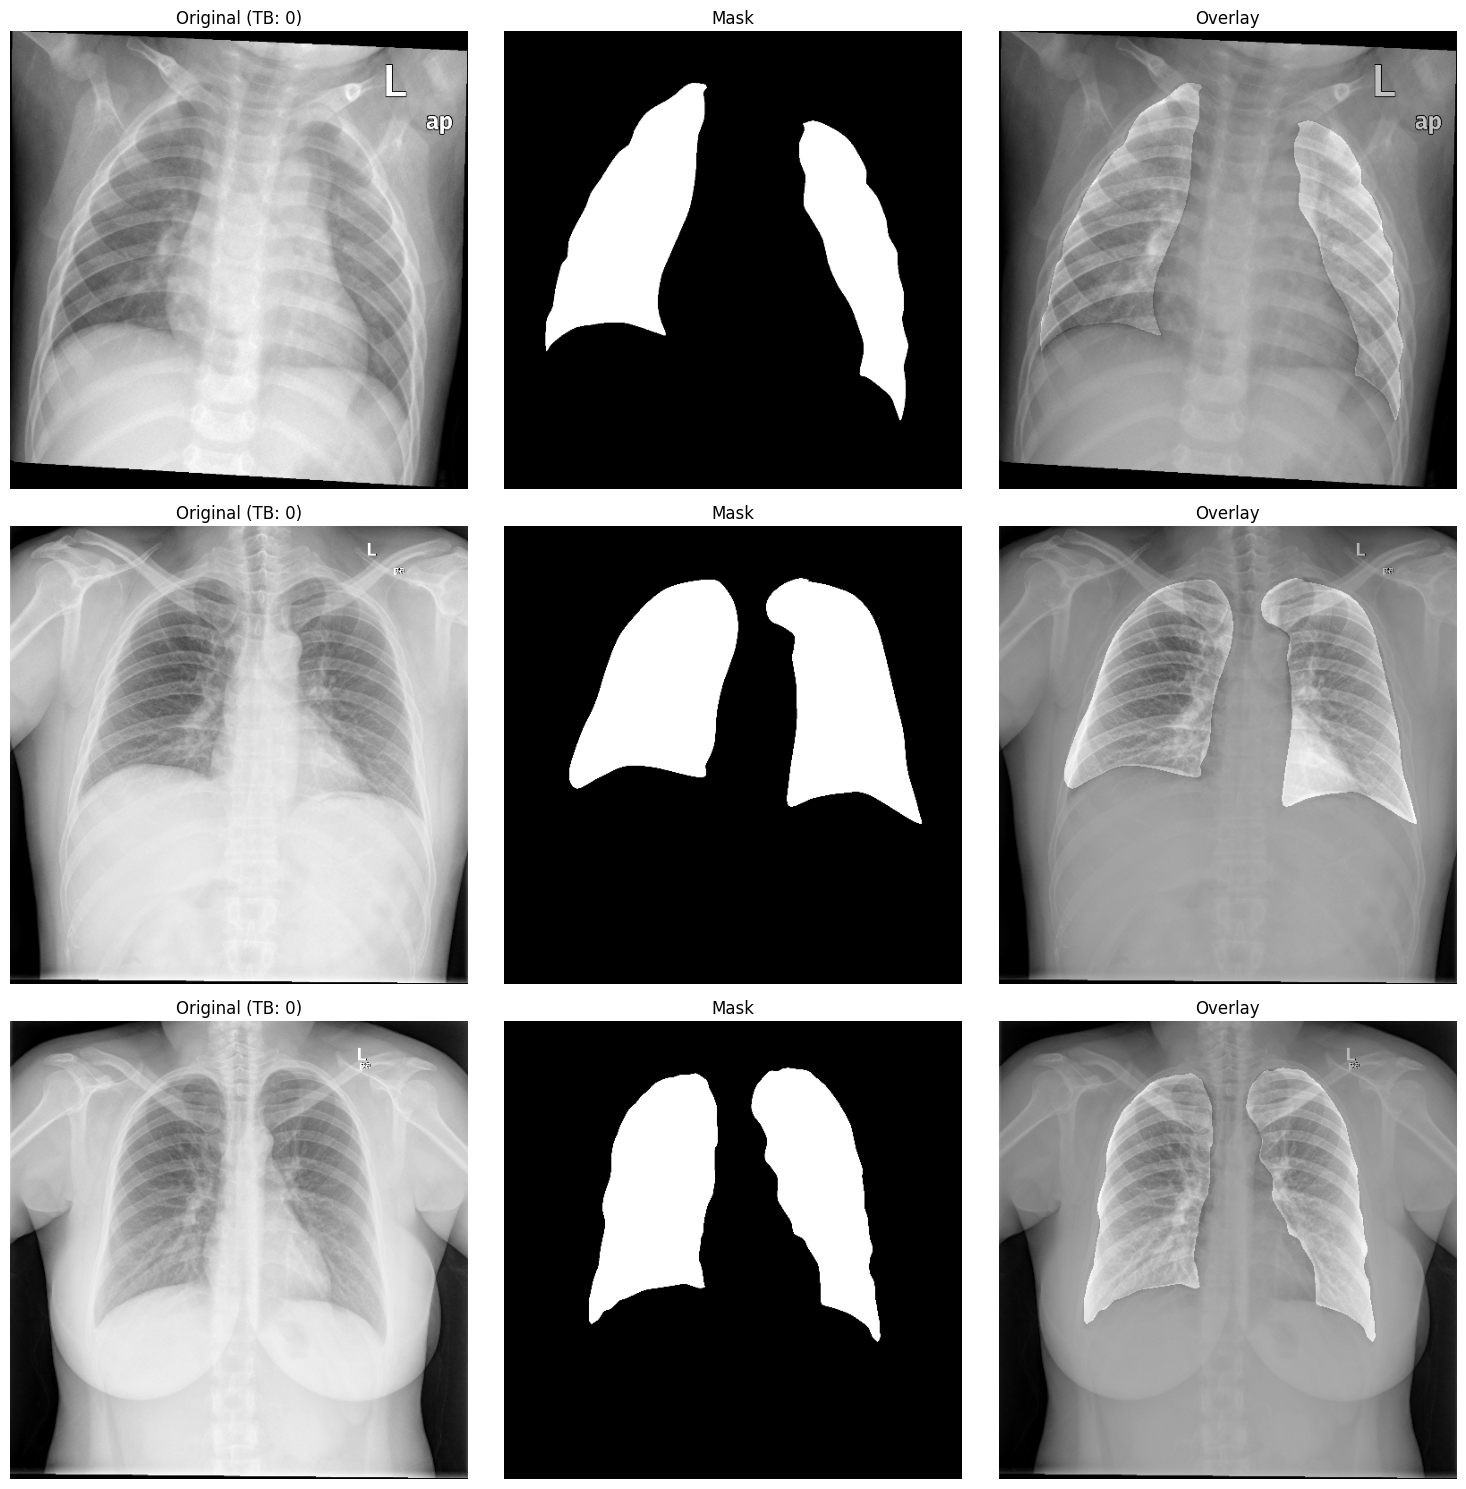

In [ ]:
# OPTIONAL: Visualize image
def display_samples(X_images, X_masks, y, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for i in range(num_samples):
        idx = np.random.randint(len(X_images))

        # Original image
        axes[i, 0].imshow(X_images[idx].squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original (TB: {y[idx]})')
        axes[i, 0].axis('off')

        # Mask
        axes[i, 1].imshow(X_masks[idx].squeeze(), cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

        # Overlay
        overlay = X_images[idx].squeeze().copy()
        overlay[X_masks[idx].squeeze() > 0.5] *= 1.5
        axes[i, 2].imshow(overlay, cmap='gray')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Display samples
print("Sample image:")
display_samples(X_images, X_masks, y)

In [ ]:
# Split data into Train and Test set
X_train_val, X_test, X_mask_train_val, X_mask_test, y_train_val, y_test = train_test_split(
    X_images, X_masks, y,
    test_size=0.2,
    stratify=y,
    random_state=10
)

# Split data into Train and Validation set
X_train, X_val, X_mask_train, X_mask_val, y_train, y_val = train_test_split(
    X_train_val, X_mask_train_val, y_train_val,
    test_size=0.2,
    stratify=y_train_val,
    random_state=10
)

print("Dataset split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Verify class distribution in splits
print("\nClass distribution in splits:")
print("Training set:", np.bincount(y_train))
print("Validation set:", np.bincount(y_val))
print("Test set:", np.bincount(y_test))

Dataset split sizes:
Training set: 450 samples
Validation set: 113 samples
Test set: 141 samples

Class distribution in splits:
Training set: [229 221]
Validation set: [58 55]
Test set: [72 69]


# **CNN Model**

In [ ]:
# 1. CNN Dual - Complex model
def create_model(input_shape=(512, 512, 1)):

    l2_val = 0.001

    # Image input branch
    img_input = layers.Input(shape=input_shape)

    # First block
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)  # 256x256

    # Second block
    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)  # 128x128

    # Third block
    x = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)  # 64x64

    # Mask input branch
    mask_input = layers.Input(shape=input_shape)

    # First block - mask
    y = layers.Conv2D(32, 3, activation='relu', padding='same')(mask_input)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)  # 256x256

    # Second block - mask
    y = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)  # 128x128

    # Third block - mask
    y = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.BatchNormalization()(y)
    y = layers.MaxPooling2D()(y)  # 64x64

    # Now both x and y have shape (batch_size, 64, 64, 128)
    # Concatenate features
    concat = layers.concatenate([x, y])

    # Shared processing after concatenation
    z = layers.Conv2D(256, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(concat)
    z = layers.BatchNormalization()(z)
    z = layers.GlobalAveragePooling2D()(z)

    # Dense layers
    z = layers.Dense(128, activation='relu')(z)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(1, activation='sigmoid')(z)

    # Create and compile model
    model = models.Model(inputs=[img_input, mask_input], outputs=output)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create and display model
model = create_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print("\nModel Summary:")
print(model.summary())


Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 512, 512, 32)   │            128 │ conv2d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 512, 512, 32)   │            128 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 256, 256, 64)   │            256 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 256, 256, 64)   │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 128, 128, 64)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)   

 Total params: 811,265 (3.09 MB)

 Trainable params: 809,857 (3.09 MB)

 Non-trainable params: 1,408 (5.50 KB)

None


In [ ]:
# 2. CNN Dual - Simple model
def create_simple_model(input_shape=(512, 512, 1)):

    l2_val = 0.001

    # Image input branch
    img_input = layers.Input(shape=input_shape, name='img_input')
    x = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(img_input)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)

    # Mask input branch
    mask_input = layers.Input(shape=input_shape, name='mask_input')
    y = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(mask_input)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Dropout(0.3)(y)
    y = layers.Flatten()(y)

    # Concatenate features
    concatenated = layers.concatenate([x, y])

    # Dense layers
    z = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_val))(concatenated)
    z = layers.Dropout(0.5)(z)
    output = layers.Dense(1, activation='sigmoid')(z)

    # Create and compile model
    model = models.Model(inputs=[img_input, mask_input], outputs=output)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create and display model
model = create_simple_model()
plot_model(model, to_file='simple_model_plot.png', show_shapes=True, show_layer_names=True)
print("\nModel Summary:")
print(model.summary())


Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_input (InputLayer)   │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 512, 512, 32)   │            320 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ mask_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 256, 256, 32)   │              0 │ conv2d_8[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 256, 256, 32)   │              0 │ conv2d_10[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 128, 128, 64)   │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 128, 128, 64)   │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128, 128, 64)   │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1048576)        │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 1048576)        │              0 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 2097152)        │              0 │ flatten_2[0][0],       │
│ (Concatenate)             │                        │                │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │    268,435,584 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 268,473,345 (1.00 GB)

 Trainable params: 268,473,345 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# 3. CNN Dual - Complex Tuned model
def create_model(input_shape=(512, 512, 1)):

    l2_val = 0.001

    # Image input branch
    img_input = layers.Input(shape=input_shape, name='img_input')

    x = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(img_input)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)

    # Mask input branch
    mask_input = layers.Input(shape=input_shape, name='mask_input')

    y = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(mask_input)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Dropout(0.3)(y)

    y = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Conv2D(256, 3, activation='relu', padding='same',
                      kernel_regularizer=regularizers.l2(l2_val))(y)
    y = layers.MaxPooling2D(2)(y)
    y = layers.Dropout(0.3)(y)

    y = layers.Flatten()(y)

    # Concatenate features
    concatenated = layers.concatenate([x, y])

    # Dense layers
    z = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_val))(concatenated)
    z = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_val))(z)
    z = layers.Dense(128, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_val))(z)
    z = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_val))(z)
    z = layers.Dropout(0.3)(z)
    output = layers.Dense(1, activation='sigmoid')(z)

    # Create and compile model
    model = models.Model(inputs=[img_input, mask_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create and display model
model = create_model()
plot_model(model, to_file='complex_model_plot.png', show_shapes=True, show_layer_names=True)
print("\nModel Summary:")
print(model.summary())


Model Summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_input (InputLayer)    │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mask_input (InputLayer)   │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ img_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 512, 512, 32)   │            320 │ mask_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_90          │ (None, 256, 256, 32)   │              0 │ conv2d_90[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_94          │ (None, 256, 256, 32)   │              0 │ conv2d_94[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_90[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 256, 256, 64)   │         18,496 │ max_pooling2d_94[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_91          │ (None, 128, 128, 64)   │              0 │ conv2d_91[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_95          │ (None, 128, 128, 64)   │              0 │ conv2d_95[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_47 (Dropout)      │ (None, 128, 128, 64)   │              0 │ max_pooling2d_91[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_49 (Dropout)      │ (None, 128, 128, 64)   │              0 │ max_pooling2d_95[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout_47[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ dropout_49[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_92          │ (None, 64, 64, 128)    │              0 │ conv2d_92[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_96          │ (None, 64, 64, 128)    │              0 │ conv2d_96[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)   

 Total params: 269,384,193 (1.00 GB)

 Trainable params: 269,384,193 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Model training
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.05,
        patience=5,
        verbose=1,
        cooldown=2,
        min_lr=1e-6
    )
]

print("Starting model training...")
history = model.fit(
    [X_train, X_mask_train],
    y_train,
    validation_data=([X_val, X_mask_val], y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting model training...
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5179 - auc: 0.5190 - loss: 3.2169
Epoch 1: val_auc improved from -inf to 0.66082, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5172 - auc: 0.5184 - loss: 3.2223 - val_accuracy: 0.4867 - val_auc: 0.6608 - val_loss: 3.3017 - learning_rate: 0.0010
Epoch 2/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5157 - auc: 0.5703 - loss: 3.1186
Epoch 2: val_auc improved from 0.66082 to 0.69044, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5204 - auc: 0.5726 - loss: 3.0930 - val_accuracy: 0.5841 - val_auc: 0.6904 - val_loss: 2.3765 - learning_rate: 0.0010
Epoch 3/50
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5966 - auc: 0.6124 - loss: 2.2097
Epoch 3: val_auc did not improve from 0.69044
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.5984 - auc: 0.6173 - loss: 2.1895 - val_accuracy: 0.5752 - val_auc: 

In [ ]:
# OPT: Training w/ Augmented Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create a generator for multiple inputs
def generator(features1, features2, labels, batch_size):
    genX1 = datagen.flow(features1, labels, batch_size=batch_size, seed=42)
    genX2 = datagen.flow(features2, labels, batch_size=batch_size, seed=42)
    while True:
        X1i = genX1.__next__()
        X2i = genX2.__next__()
        yield (X1i[0], X2i[0]), X1i[1]


callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.05,
        patience=5,
        verbose=1,
        cooldown=2,
        min_lr=1e-6
    )
]

batch_size = 32
train_generator = generator(X_train, X_mask_train, y_train, batch_size)

print("Starting model training...")
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=([X_val, X_mask_val], y_val),
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Starting model training...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.6556 - auc: 0.6932 - loss: 6.1436
Epoch 1: val_auc improved from -inf to 0.66113, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6558 - auc: 0.6945 - loss: 6.1408 - val_accuracy: 0.5133 - val_auc: 0.6611 - val_loss: 6.2343 - learning_rate: 5.0000e-05
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.6744 - auc: 0.7124 - loss: 6.1031
Epoch 2: val_auc did not improve from 0.66113
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 963ms/step - accuracy: 0.6727 - auc: 0.7109 - loss: 6.1036 - val_accuracy: 0.5133 - val_auc: 0.6154 - val_loss: 6.1998 - learning_rate: 5.0000e-05
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.6617 - auc: 0.6950 - loss: 6.0591
Epoch 3: val_auc did not improve from 0.66113
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 953ms/step - accuracy: 0.6629 - auc: 0.6965 - loss: 6.0555 - val_accuracy: 0.5133 - val_auc: 0.6111 - val_loss: 6.69

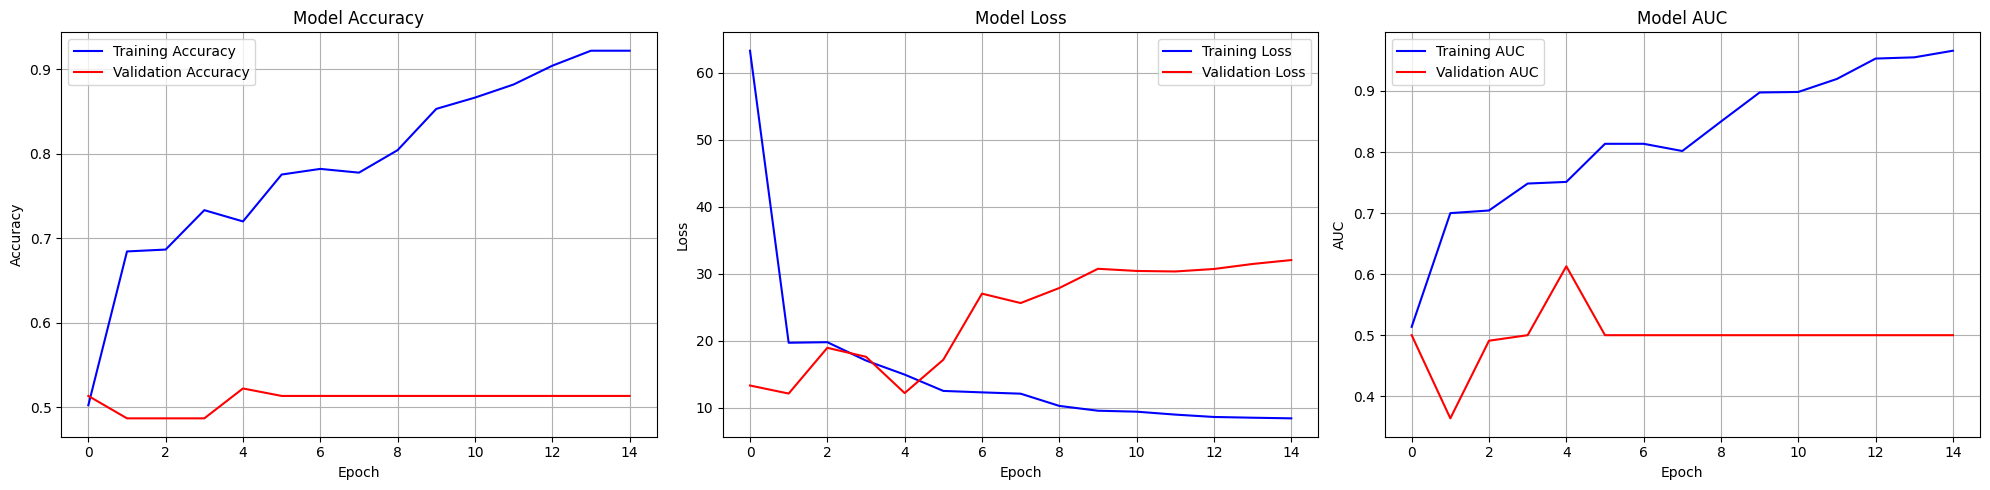


Training Results:
Total Epochs Trained: 15
Final Training Accuracy: 0.9222
Final Validation Accuracy: 0.5133
Final Training AUC: 0.9659
Final Validation AUC: 0.5000
Final Training Loss: 8.4303
Final Validation Loss: 32.0524


In [ ]:
# Print training metrics
plt.figure(figsize=(20, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Training AUC', color='blue')
plt.plot(history.history['val_auc'], label='Validation AUC', color='red')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
final_epoch = len(history.history['accuracy'])
print("\nTraining Results:")
print(f"Total Epochs Trained: {final_epoch}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training AUC: {history.history['auc'][-1]:.4f}")
print(f"Final Validation AUC: {history.history['val_auc'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        72
           1       0.00      0.00      0.00        69

    accuracy                           0.51       141
   macro avg       0.26      0.50      0.34       141
weighted avg       0.26      0.51      0.35       141



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Test Metrics:
Test Accuracy: 0.5106
Test AUC: 0.6587
Test Loss: 6.4624


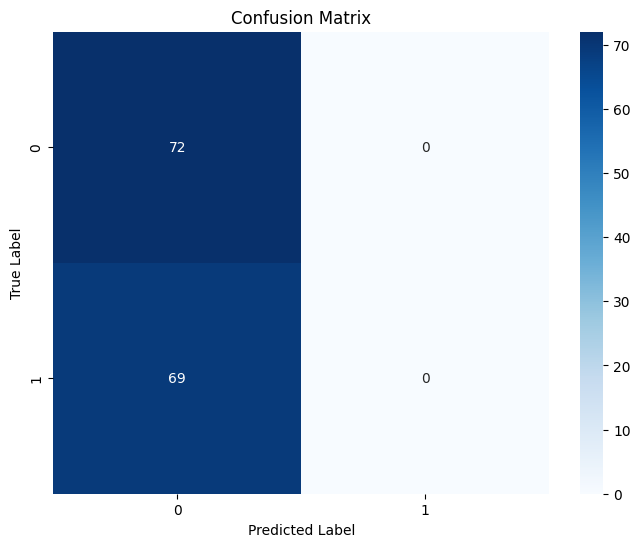

In [ ]:
# Model testing
y_pred = model.predict([X_test, X_mask_test])
y_pred_binary = (y_pred > 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Calculate and print additional metrics
test_loss, test_accuracy, test_auc = model.evaluate(
    [X_test, X_mask_test],
    y_test,
    verbose=0
)

# Print testing metrics
print("\nTest Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Displaying example predictions:


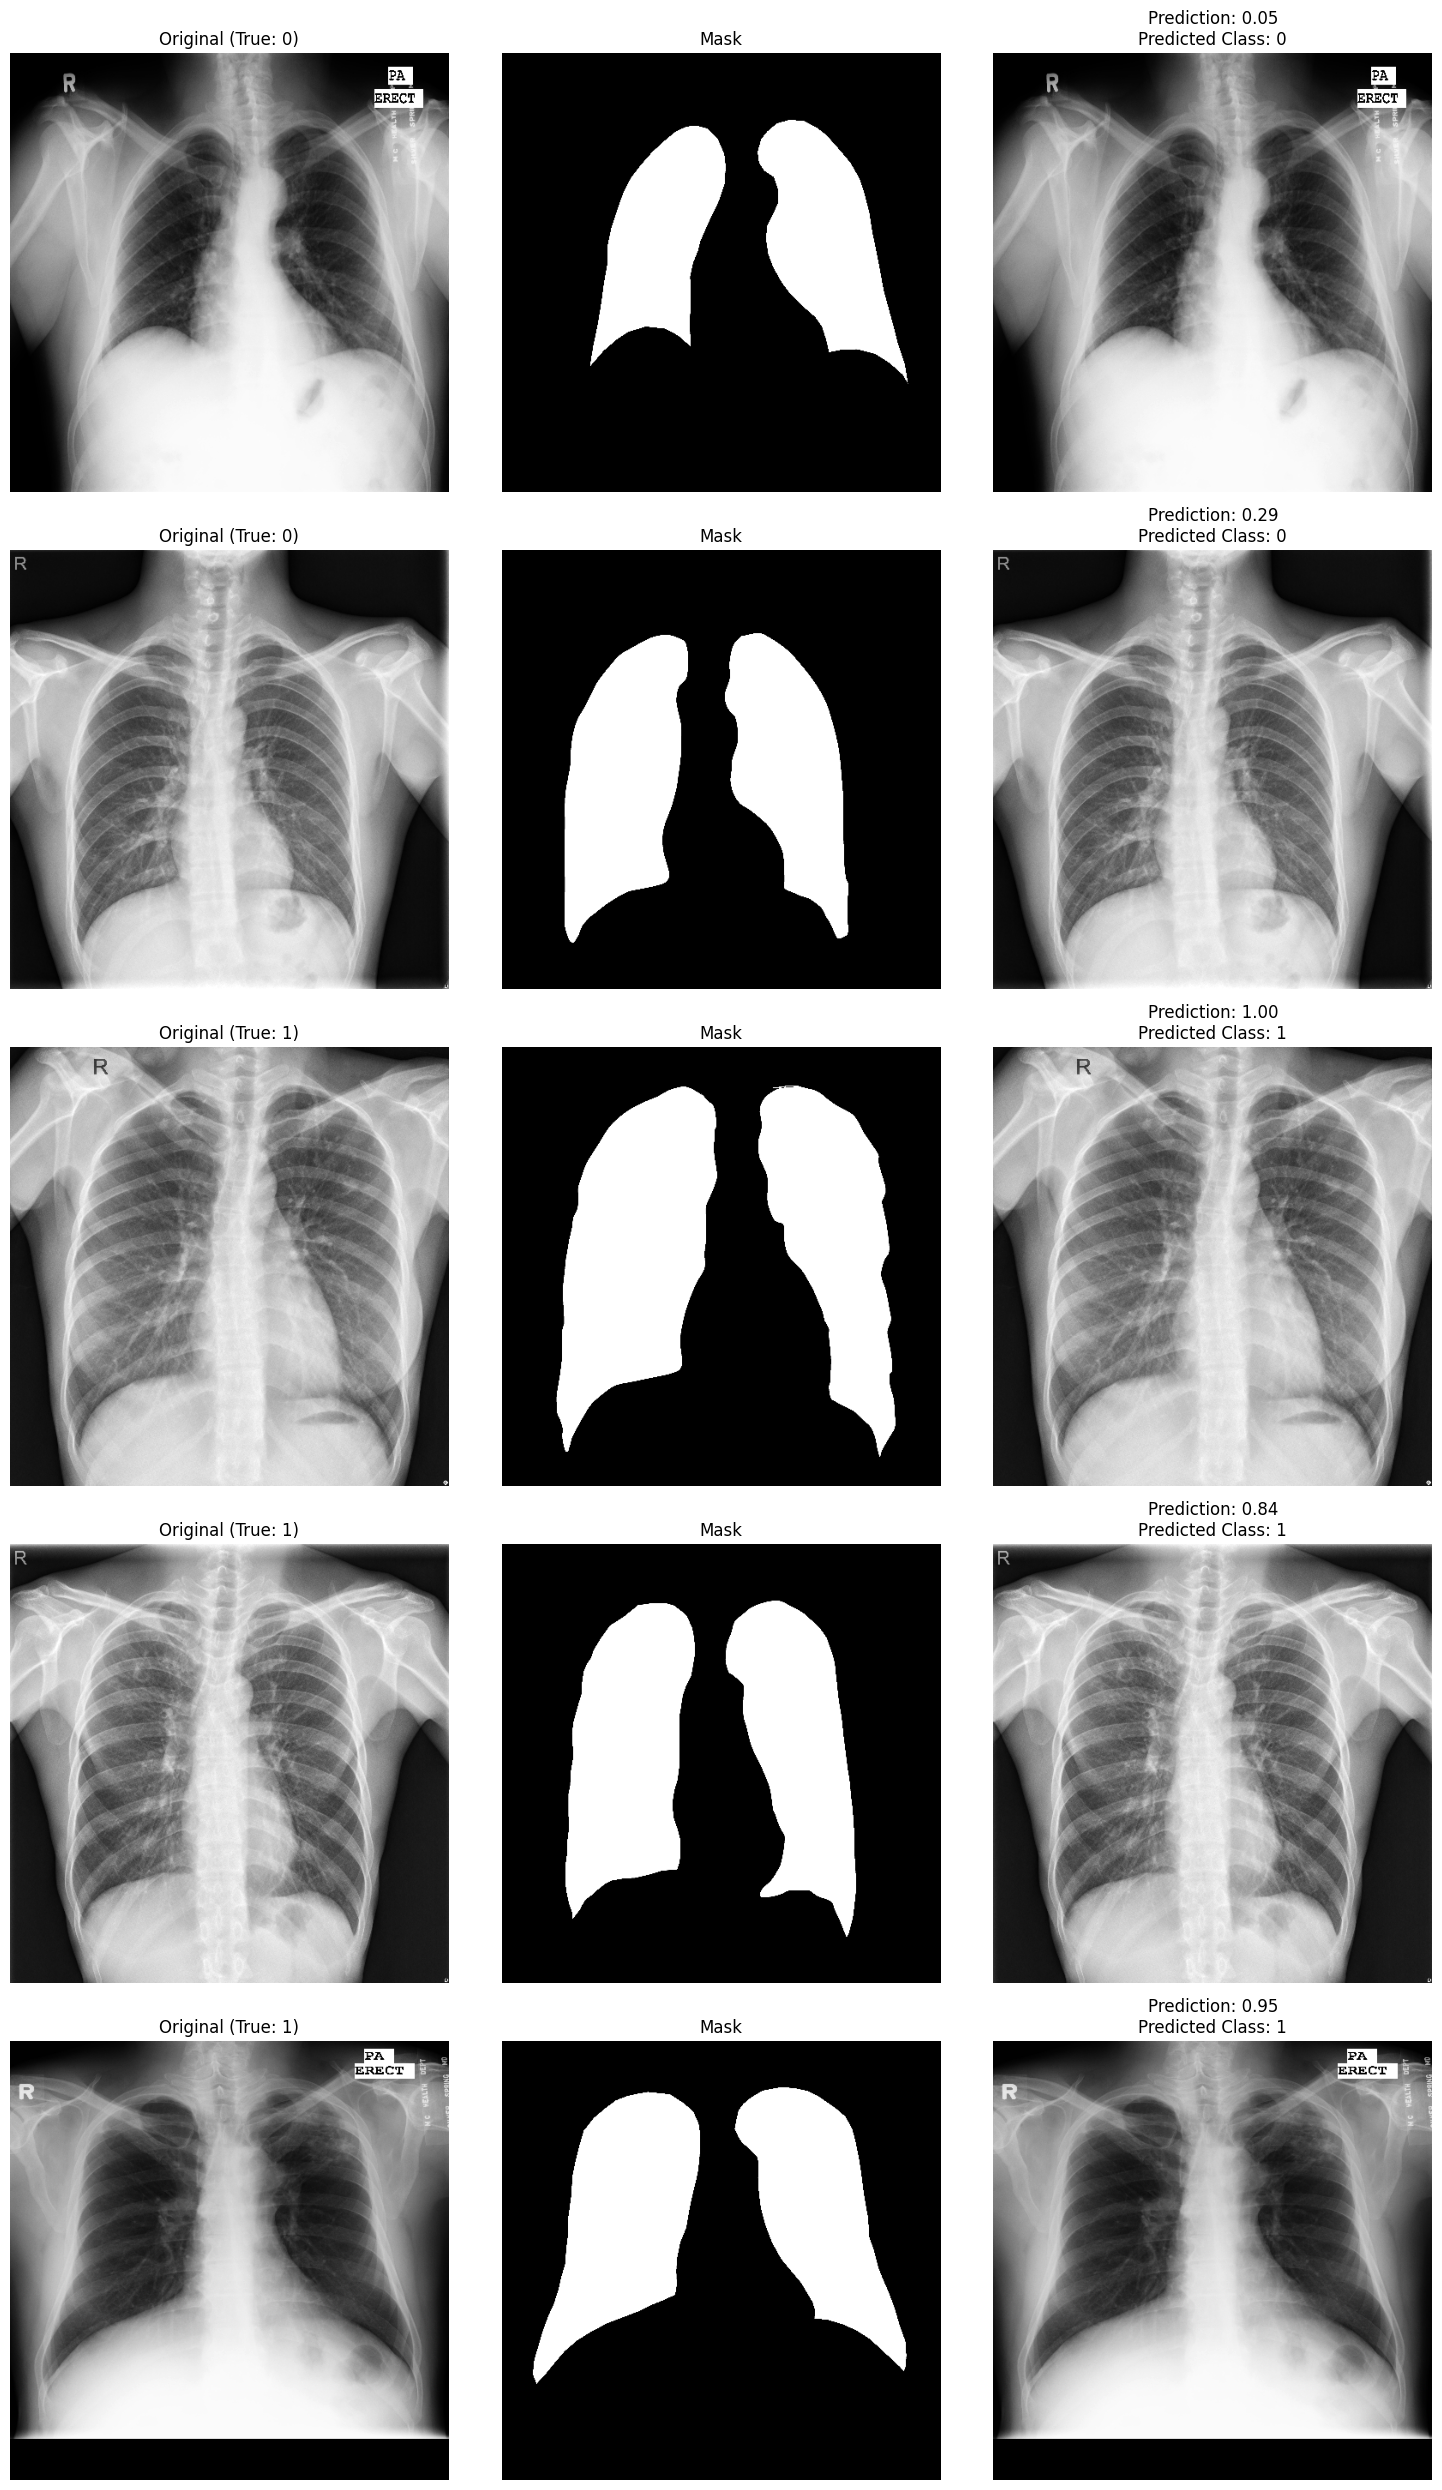

In [ ]:
# Display some prediction examples
def display_predictions(X_images, X_masks, y_true, y_pred, num_samples=5):
    indices = np.random.randint(0, len(y_true), num_samples)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

    for idx, i in enumerate(indices):
        # Original image
        axes[idx, 0].imshow(X_images[i].squeeze(), cmap='gray')
        axes[idx, 0].set_title(f'Original (True: {y_true[i]})')
        axes[idx, 0].axis('off')

        # Mask
        axes[idx, 1].imshow(X_masks[i].squeeze(), cmap='gray')
        axes[idx, 1].set_title('Mask')
        axes[idx, 1].axis('off')

        # Prediction
        axes[idx, 2].imshow(X_images[i].squeeze(), cmap='gray')
        pred_prob = y_pred[i][0]
        axes[idx, 2].set_title(f'Prediction: {pred_prob:.2f}\nPredicted Class: {int(pred_prob > 0.5)}')
        axes[idx, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying example predictions:")
display_predictions(X_test, X_mask_test, y_test, y_pred)

# **RESNET Model**

In [ ]:
#3. Using ResNet model
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)  # Add permute
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet.to(device)

# Define optimizer, scheduler, and loss function
LR = 0.1
GAMMA = 0.1
STEP = 10
optimizer = optim.SGD(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)
criterion = nn.CrossEntropyLoss()

# Training function
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, np.array(all_labels), np.array(all_predictions)

In [ ]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step()

Epoch 1/20
Train Loss: 0.6880, Train Acc: 0.5990
Val Loss: 0.6882, Val Acc: 0.5000
Epoch 2/20
Train Loss: 0.6818, Train Acc: 0.6354
Val Loss: 0.5912, Val Acc: 0.7708
Epoch 3/20
Train Loss: 0.5984, Train Acc: 0.6979
Val Loss: 0.5376, Val Acc: 0.7083
Epoch 4/20
Train Loss: 0.5787, Train Acc: 0.7135
Val Loss: 0.8287, Val Acc: 0.5000
Epoch 5/20
Train Loss: 0.5058, Train Acc: 0.7656
Val Loss: 0.7567, Val Acc: 0.5000
Epoch 6/20
Train Loss: 0.4782, Train Acc: 0.8073
Val Loss: 0.5598, Val Acc: 0.6042
Epoch 7/20
Train Loss: 0.4960, Train Acc: 0.7812
Val Loss: 0.7451, Val Acc: 0.5000
Epoch 8/20
Train Loss: 0.4723, Train Acc: 0.7865
Val Loss: 1.1706, Val Acc: 0.5000
Epoch 9/20
Train Loss: 0.3446, Train Acc: 0.8594
Val Loss: 0.9784, Val Acc: 0.5000
Epoch 10/20
Train Loss: 0.2623, Train Acc: 0.8906
Val Loss: 0.9028, Val Acc: 0.5000
Epoch 11/20
Train Loss: 0.2624, Train Acc: 0.9115
Val Loss: 0.3409, Val Acc: 0.8333
Epoch 12/20
Train Loss: 0.1498, Train Acc: 0.9583
Val Loss: 0.2764, Val Acc: 0.8542
E

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.83      0.83        30
     Class 1       0.83      0.83      0.83        30

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

Test Metrics:
Test Accuracy: 0.8333
Test Loss: 0.3931


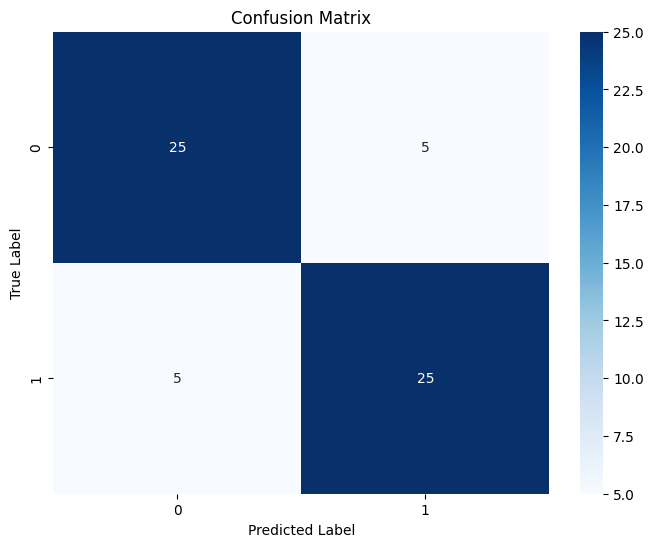

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_labels, test_predictions = evaluate(model, test_loader, criterion, device)
report = classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

# Print testing metrics
print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()